In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import os.path
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, ReLU
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dropout, Flatten,Input
import time
from keras.utils.vis_utils import plot_model
from keras.datasets.fashion_mnist import load_data
from IPython import display

import glob
import random
import imageio
import PIL, cv2
import pandas as pd
%matplotlib inline
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

<ipython-input-1-8b863c13f0ab>:26: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [ ]:
!pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/ 

! chmod 600 ~/.kaggle/kaggle.json

!pip install pyyaml h5py

#per python vanno modificati. Niente "!" e nuovi comandi non-unix|linux (e.g. cp non esiste)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Download and preproccess data

In [ ]:
! kaggle datasets download ruizgara/socofing

! unzip socofing.zip

In [ ]:
def pathing_export(input_list,empty_one,empty_two):
    
    for img_path in input_list:
        main_path,document_type = os.path.splitext(img_path)
        ID_pathing,other_type = main_path.split("__")
        _,rotation_path,finger_ID,_ = other_type.split("_")
        empty_one.append(img_path)
        empty_two.append(f"{rotation_path}_{finger_ID}")

In [ ]:
Main_Real_Data = Path("/content/SOCOFing/Real")


BMP_Path = []
BMP_Labels = []

BMP_All_List = list(Main_Real_Data.glob(r"*.BMP"))
pathing_export(BMP_All_List,BMP_Path,BMP_Labels)

BMP_Path_Series = pd.Series(BMP_Path,name="BMP").astype(str)
BMP_Labels_Series = pd.Series(BMP_Labels,name="CATEGORY")

Main_Finger_Data = pd.concat([BMP_Path_Series,BMP_Labels_Series],axis=1)
#print(Main_Finger_Data.head(-1))

In [ ]:
Transformation_Data = []

for IMG_X in Main_Finger_Data["BMP"]:
    x_IMG = cv2.imread(IMG_X)
    x_IMG = cv2.resize(x_IMG,(180,180))
    x_IMG = x_IMG / 255.
    Transformation_Data.append(x_IMG)

#print(Transformation_Data[3].shape)

train_images = np.asarray(Transformation_Data)
train_images = train_images.reshape(-1,180,180,3)
#print(train_images.shape)

In [ ]:
BUFFER_SIZE = 6000
BATCH_SIZE = 8

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Define the generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential(name='generator')
    model.add(Input(shape=(180,)))
    model.add(Dense(128*90*90))
    model.add(LeakyReLU())
    model.add(Reshape((90,90,128)))
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(128,4,padding="same",strides=2))
    model.add(LeakyReLU())
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU())
    model.add(Conv2D(128,3,padding="same"))
    model.add(LeakyReLU())
    model.add(Conv2D(128,3,padding="same"))
    model.add(LeakyReLU())
    model.add(Conv2D(3,7,padding="same",activation="tanh"))

    return model

In [ ]:
generator = make_generator_model()
generator.build()
#generator.summary()

In [ ]:
noise = tf.random.normal([1, 180])
generated_image = generator(noise, training=False)

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#plot_model(generator, show_shapes=True, show_layer_names=True)

# Define the Discriminator

In [ ]:
def make_discriminator_model():
  
    model = tf.keras.Sequential(name='discriminator')
    model.add(Input(shape=(180,180,3)))
    model.add(Conv2D(128,3))
    model.add(LeakyReLU())
    model.add(Conv2D(128,4,strides=2))
    model.add(LeakyReLU())
    model.add(Conv2D(128,4,strides=2))
    model.add(LeakyReLU())
    model.add(Conv2D(128,4,strides=2))
    model.add(LeakyReLU())
    model.add(Conv2D(128,3,strides=2))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.build()
#discriminator.summary()
#plot_model(discriminator, show_shapes=True, show_layer_names=True)

# Prepare and define the losses. 
Remember, Gans are a minimax 2 players game.

In [ ]:
decision = discriminator(generated_image, training=False)

print(decision)

tf.Tensor([[0.5000423]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output, fake_output):
  
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output):
  
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    return gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
#from keras.models import load_model

#generator = tf.keras.models.load_model('Fingerprint_generator.h5')
#discriminator = tf.keras.models.load_model('Fingerprint_discriminator.h5')

In [ ]:
EPOCHS = 250
noise_dim = 180
num_examples_to_generate = 12
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, generator_optimizer, discriminator_optimizer, noise_dim):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs, generator_optimizer, discriminator_optimizer, noise_dim):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, generator_optimizer, discriminator_optimizer, noise_dim)

    # Produce images
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print(type(predictions))
  print(type(model))
  print(type(test_input))

  fig = plt.figure(figsize=(7, 7))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'keras.engine.sequential.Sequential'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


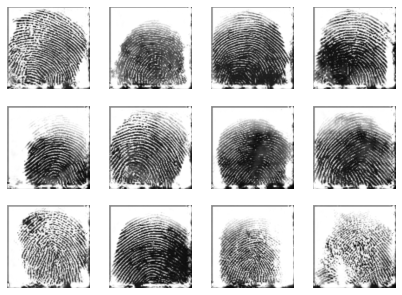

In [ ]:
train(train_dataset, EPOCHS, generator_optimizer, discriminator_optimizer, noise_dim)

generator.save('Fingerprint_generator.h5')
discriminator.save('Fingerprint_discriminator.h5')

Now the generator is trained; therefore, if we are satisfied with the quality of the generated images, we can create a small dataset of generated images.

In [ ]:
folder_name = "generated_fingerprints"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/model.h5' with the actual path to your h5 file
generator = load_model('/content/Fingerprint_generator.h5')
